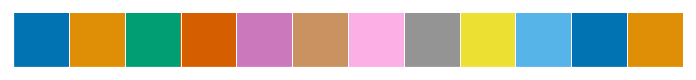

In [50]:
%matplotlib inline
import os
import sys
os.environ['PROJ_LIB']=os.path.join(os.environ['HOME'],'.anaconda3','share','proj')

import astropy.units as units
from brewer2mpl import qualitative, diverging
#import cufflinks as cf
#cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
#import h5py
#from IPython.display import HTML
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import cm as cm2
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
import numpy as np
import palettable as colortable
from palettable.cartocolors.diverging import Earth_3, Tropic_3_r, Tropic_3
from palettable.colorbrewer.diverging import PuOr_3, RdBu_11
from palettable.colorbrewer.sequential import BuGn_9, Blues_9
from palettable.mycarta import LinearL_20, CubeYF_12
from palettable.cmocean.diverging import Balance_9
import pandas as pd
import pytz
import seaborn as sns
import xarray as xr


sns.set()
fontsize = 30
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : fontsize}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = [15.0,10.0]
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'


pal = sns.palplot(sns.color_palette("colorblind", 12))
sns.set_style("whitegrid", {'axes.grid':True, 'ticks':True})
plt.style.use("seaborn-paper")
sns.set_context('paper')
sns.set_palette(pal)
sns.despine()
np.warnings.filterwarnings('ignore')
utc = pytz.UTC
timezone = pytz.timezone('Australia/Darwin')
paper_path = os.path.join(os.environ['HOME'], 'Work', 'Paper', '2018', 'Hector')
date_fmt = mdates.DateFormatter('%b %d')
pal

In [44]:
colm = ListedColormap(sns.color_palette("colorblind", 12).as_hex())

In [48]:
UM133ens = xr.open_dataset('rain_rate_um133.nc')
UM044ens = xr.open_dataset('rain_rate_um044.nc')
OBS = xr.open_dataset('rain_rate_observation.nc')
plot_data = pd.read_pickle('diurnal_cycle.pkl')

In [4]:
lat1, lon1 = OBS.variables['latitude'][:], OBS.variables['longitude'][:]
lat2, lon2 = UM044ens.coords['lat'][:], UM044ens.coords['lon'][:]
m2 = Basemap(llcrnrlat=min(lat2), llcrnrlon=min(lon2), urcrnrlat=max(lat2), urcrnrlon=max(lon2), 
              resolution='f', area_thresh=1)


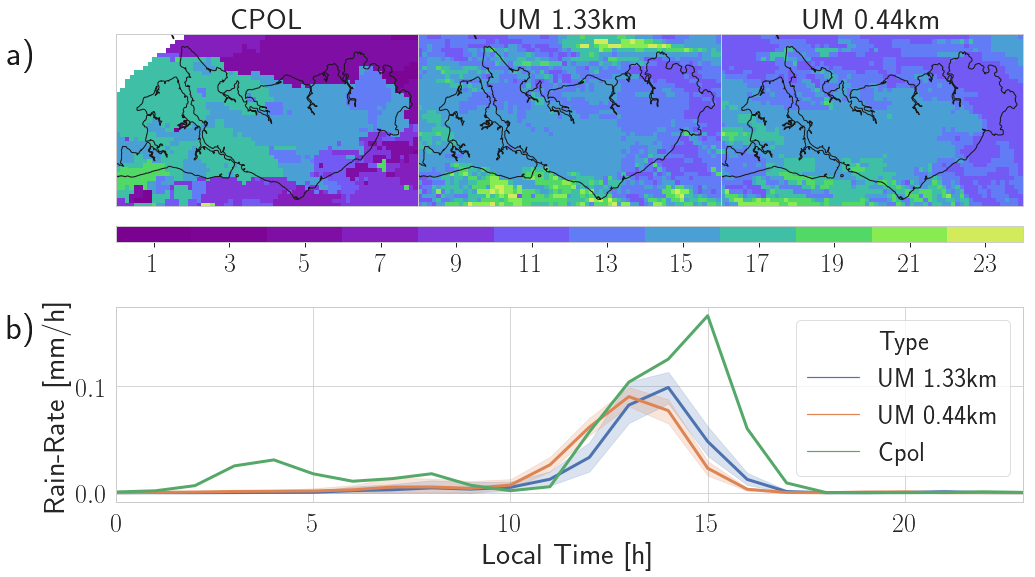

In [76]:
#Plot the maps
%matplotlib inline
um_1 = UM044ens.groupby('t.hour').mean(dim='t').mean(dim=('surface'))
um_2 = UM133ens.groupby('t.hour').mean(dim='t').mean(dim=('surface'))
obs  = OBS.groupby('t.hour').mean(dim='t')

time = (um_1.hour + 9) % 24

data = [obs, um_2, um_1]

#ax = [fig.add_subplot(2,3,1)]
mm, im = [], []
col = 2
day = (time[1:5] - 9) % 24
night = (time[5:5+4] - 9) % 24
obs_diff = obs['lsrain'][day].sum(dim='hour') - obs['lsrain'][night].sum('hour')
um_1_diff = um_1['lsrain'][day].sum(dim='hour') - um_1['lsrain'][night].sum('hour')
um_2_diff = um_2['lsrain'][day].sum(dim='hour') - um_2['lsrain'][night].sum('hour')

mask = np.ma.masked_invalid(obs['lsrain'].values) * 0 + 1
obs_max = (((np.argmax(obs['lsrain'].values * mask, axis=0)*mask[0] + 9.5 ) % 24)/2).round(0) * 2
um_1_max = ((um_1['lsrain'].argmax(dim='hour').mean(dim='ens').round(0) + 9.5) % 24 / 2).round(0) * 2 
um_2_max = ((um_2['lsrain'].argmax(dim='hour').mean(dim='ens').round(0) + 9.5) % 24 / 2).round(0) * 2

colm = CubeYF_12.get_mpl_colormap(N=12, gamma=2.0)
colm.set_bad('w')
#m, ax = [], []
ax = []
data = [obs_max, um_1_max, um_2_max]
names = ['CPOL', 'UM 1.33km', 'UM 0.44km']
gs = gridspec.GridSpec(30, 3)

fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(right=0.98, bottom=0.03, top=0.98,left=0.01, hspace=0, wspace=0)
cbar_ax = plt.subplot(gs[13, :])
#"""
for i in range(3):
    ax.append(plt.subplot(gs[:13, i]))
    m2.drawcoastlines()
    try:
        im = m2.pcolormesh(lon1, lat1, data[i], vmin=0, vmax=24, cmap=colm)
    except TypeError:
        im = m2.pcolormesh(lon2, lat2, data[i], vmin=0, vmax=24, cmap=colm)
    ax[-1].set_title(names[i], fontsize=fontsize)
cbar=fig.colorbar(im, cax=cbar_ax, orientation='horizontal',ticks=list(range(1,24,2)))
cbar.ax.tick_params(labelsize=fontsize-4)
#cbar.set_label('Local Time [h]', size=fontsize)
# Plot avg diurnal cycle
#Get the minimum time period that is covered by all simulations and also observations
#fig = plt.figure(figsize=(15,8), dpi=72)
#ax = fig.add_subplot(111)
ax[0].text(-0.36, 0.98, 'a)',
        verticalalignment='top', horizontalalignment='left',
        transform=ax[0].transAxes,
        color='k', fontsize=35)
#"""
ax = plt.subplot(gs[18:, :])
####################
sns.lineplot(x=plot_data.time, y=plot_data.data, hue=plot_data.Type, ax=ax, lw=3, data=plot_data)
#ax.set_ylim(0.0,0.42)
ax.set_xlim(0,23)
ax.set_ylabel('Rain-Rate [mm/h]', fontsize=fontsize)
ax.set_xlabel('Local Time [h]', fontsize=fontsize)
ax.legend(loc=0, fontsize=fontsize-4)
ax.tick_params(labelsize=fontsize-4)
fig.subplots_adjust(bottom=0.145, top=0.99, right=0.99, left=0.15)
_ = ax.text(-0.12, 0.98, 'b)',
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='k', fontsize=35)
_ = fig.savefig(os.path.join(paper_path, 'Figure_05.pdf'), bbox_set_inches='tight', dpi=300)